In [92]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import FashionMNIST, MNIST
from torchvision import transforms
import pytorch_lightning as pl

from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

In [40]:
class LitAutoEncoder(pl.LightningModule):
	def __init__(self):
		super().__init__()
		self.encoder = nn.Sequential(
								nn.Linear(28 * 28, 64),
								nn.ReLU(),
								nn.Linear(64, 3))
		self.decoder = nn.Sequential(
								nn.Linear(3, 64),
								nn.ReLU(),
								nn.Linear(64, 28 * 28))

	def forward(self, x):
		embedding = self.encoder(x)
		return embedding

	def configure_optimizers(self):
		optimizer = torch.optim.SGD(self.parameters(), lr=1e-1)
		return optimizer

	def training_step(self, train_batch, batch_idx):
		x, y = train_batch
		x = x.view(x.size(0), -1)
		z = self.encoder(x)    
		x_hat = self.decoder(z)
		loss = F.mse_loss(x_hat, x)
		self.log('train_loss', loss)
		return loss

	def validation_step(self, val_batch, batch_idx):
		x, y = val_batch
		x = x.view(x.size(0), -1)
		z = self.encoder(x)
		x_hat = self.decoder(z)
		loss = F.mse_loss(x_hat, x)
		self.log('val_loss', loss)
        
	def img_reconstruction(self, img):
		encoded_x = self.encoder.forward(img.reshape(-1))
		decoded_x = self.decoder.forward(encoded_x)
		recon_img = decoded_x.detach().numpy()
		recon_img = img.reshape(28,28,1)
		fig = plt.figure()
		ax1 = fig.add_subplot(1,2,1)
		ax1.imshow(img)
		ax2 = fig.add_subplot(2,2,2)
		ax2.imshow(recon_img)
    
        

In [ ]:
# data
dataset = MNIST('', train=True, download=True, transform=transforms.ToTensor())
mnist_train, mnist_val = random_split(dataset, [55000, 5000])

train_loader = DataLoader(mnist_train, batch_size=32,num_workers=4)
val_loader = DataLoader(mnist_val, batch_size=32,num_workers=4)

# model
model = LitAutoEncoder()

# training
#trainer = pl.Trainer(gpus=1, num_nodes=8, precision=16, limit_train_batches=0.5)
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="auto",
    # num_nodes=8, dont use in a notebook, use only in workstations
    precision=16,
    # devices= 1,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[TQDMProgressBar(refresh_rate=5)]
)
trainer.fit(model, train_loader, val_loader)


In [45]:
dataset[10][0].reshape(-1).shape

torch.Size([784])

In [46]:
dataset[10][1]

3

In [47]:
encoded_x = model.encoder.forward(dataset[10][0].reshape(-1))
decoded_x = model.decoder.forward(encoded_x)
decoded_x.shape

torch.Size([784])

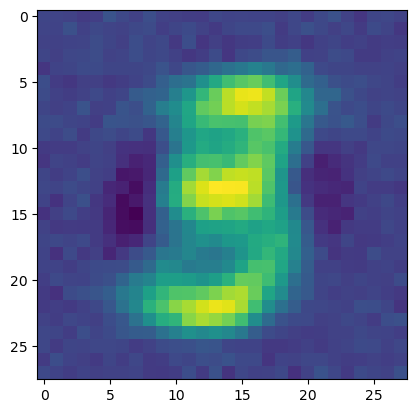

In [48]:

img = decoded_x.detach().numpy()
img = img.reshape(28,28,1)
plt.imshow(img)

In [39]:
out = model.forward(dataset[10][0].reshape(-1))
out

tensor([ 0.2075, -0.0806,  0.2266], grad_fn=<AddBackward0>)

In [71]:
val_data = DataLoader(mnist_val, batch_size=2000,num_workers=4)

In [72]:

f, l = next(iter(val_data))


/opt/homebrew/Caskroom/miniforge/base/envs/rp_hw/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/rp_hw/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <0C2433AA-B0F3-3426-9D3B-51D4A9EF55C9> /opt/homebrew/Caskroom/miniforge/base/envs/rp_hw/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <F0A76E4B-C132-362D-AB17-78D967F7A0EB> /opt/homebrew/Caskroom/miniforge/base/envs/rp_hw/lib/python3.8/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/Caskroom/miniforge/base/envs/rp_hw/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/rp_hw/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __

In [75]:
f.shape

torch.Size([2000, 1, 28, 28])

In [76]:
f.view(f.size(0), -1).shape

torch.Size([2000, 784])

In [77]:


encoder_predictions = model.forward(f.view(f.size(0), -1))
tsne = TSNE()
tsne_2d = tsne.fit_transform(encoder_predictions.detach().numpy())

/opt/homebrew/Caskroom/miniforge/base/envs/rp_hw/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/rp_hw/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


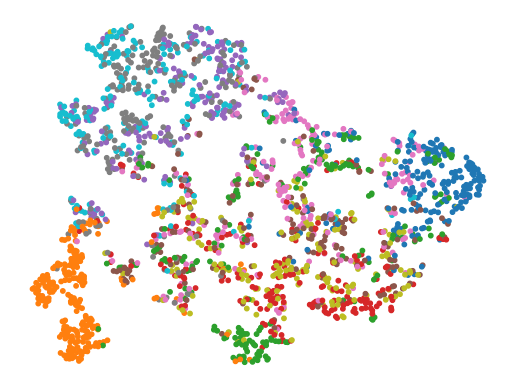

In [79]:
plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1], c=l, s=10, cmap="tab10")
plt.axis("off")
plt.show()

In [95]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

def plot_results(tsne_2d,x,y):
    plt.figure(figsize=(10, 8))
    cmap = plt.cm.tab10
    plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1], c=y, s=10, cmap=cmap)
    image_positions = np.array([[1., 1.]])
    for index, position in enumerate(tsne_2d):
        dist = np.sum((position - image_positions) ** 2, axis=1)
        if np.min(dist) > 100: # if far enough from other images
            image_positions = np.r_[image_positions, [position]]
            imagebox = mpl.offsetbox.AnnotationBbox(
                mpl.offsetbox.OffsetImage(x[index].reshape(28,28), cmap="binary"),
                position, bboxprops={"edgecolor": cmap(y[index]), "lw": 2})
            plt.gca().add_artist(imagebox)
    plt.axis("off")
    # save_fig("fashion_mnist_visualization_plot")
    plt.show()

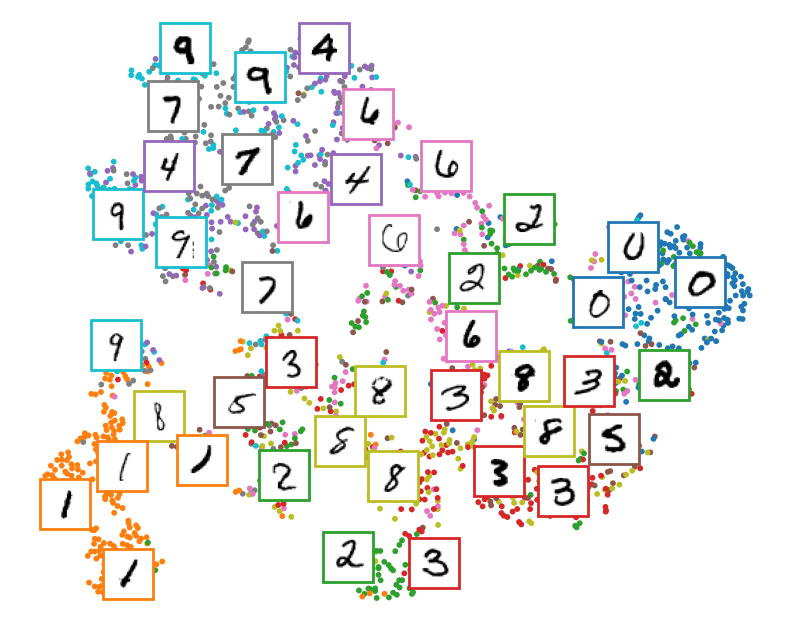

In [96]:
plot_results(tsne_2d,f,l)